In [1]:
import sys
sys.path.append('/Users/aidanmorrison/bayesnets')

In [81]:
from swarm import core
from swarm import io
import json
import basic_hive
import importlib
from matplotlib import pyplot as plt
import utils
import numpy as np
import pandas as pd
import itertools
import torch
from torch import nn

In [89]:
importlib.reload(basic_hive)
importlib.reload(utils)

<module 'utils' from '/Users/aidanmorrison/bayesnets/experiments/goofy/utils.py'>

In [90]:
reslist, static_params = basic_hive.main()

In [11]:
data,loss, xy, params = utils.unpacker(reslist, static_params)

In [12]:
data_df, loss_df, xy_df, param_df = utils.make_frames(data, loss, xy, static_params, params)


In [13]:
long_data = pd.melt(data_df,id_vars = ['swarm', 'bee', 'epoch'], var_name = 'x', value_name = 'ypred')

In [14]:
long_data['x'] = long_data['x'].astype(float)

In [15]:
df = long_data.merge(param_df, how = 'left', left_on = 'swarm', right_on = 'swarm')

In [16]:
df = df.merge(loss_df, how = 'left', left_on = ['swarm', 'bee', 'epoch'], right_on = ['swarm', 'bee', 'epoch'])

In [18]:
df.head()

,swarm,bee,epoch,x,ypred,hidden,width,num_epochs,activation,momentum,lr,loss
0,0.0,0.0,0,-5.0,0.506800,1,10,100,<class 'swarm.activations.xTanH'>,0.9,0.02,0.428847
1,0.0,0.0,1,-5.0,0.496933,1,10,100,<class 'swarm.activations.xTanH'>,0.9,0.02,0.427726
2,0.0,0.0,2,-5.0,0.481790,1,10,100,<class 'swarm.activations.xTanH'>,0.9,0.02,0.425760
3,0.0,0.0,3,-5.0,0.467499,1,10,100,<class 'swarm.activations.xTanH'>,0.9,0.02,0.423150
4,0.0,0.0,4,-5.0,0.459486,1,10,100,<class 'swarm.activations.xTanH'>,0.9,0.02,0.419922


In [91]:
df = basic_hive.get_long_results(width_list = [1,5,10], momentum_list = [0.7, 0.9], lr_list = [0.002, 0.02] )

In [92]:
df.head()

,swarm,bee,epoch,x,ypred,y,hidden,width,num_epochs,activation,momentum,lr,loss
0,0.0,0.0,0,-5.0,0.223316,0.958924,1,1,100,<class 'swarm.activations.xTanH'>,0.7,0.002,0.589496
1,0.0,0.0,1,-5.0,0.222445,0.958924,1,1,100,<class 'swarm.activations.xTanH'>,0.7,0.002,0.589049
2,0.0,0.0,2,-5.0,0.220967,0.958924,1,1,100,<class 'swarm.activations.xTanH'>,0.7,0.002,0.588294
3,0.0,0.0,3,-5.0,0.219069,0.958924,1,1,100,<class 'swarm.activations.xTanH'>,0.7,0.002,0.587332
4,0.0,0.0,4,-5.0,0.216885,0.958924,1,1,100,<class 'swarm.activations.xTanH'>,0.7,0.002,0.586237


In [93]:
frame = df[df['epoch']==49]
param_frame = frame[['hidden', 'width', 'activation', 'momentum', 'lr']].drop_duplicates()
param_frame.shape

(36, 5)

In [94]:
facet_x = 'lr'
facet_y = 'momentum'

In [95]:
for freeparam in param_frame.drop([facet_x, facet_y], axis = 1).columns:
    unique_vals = param_frame[freeparam].unique()
    if len(unique_vals) > 1:
        print("parameter " + freeparam + ' has values: ')
        for val in unique_vals:
            print(str(val))
        print('first filter data frame so that only one unique value remains, or assign to shape or linetype variable')
        


parameter width has values: 
1
5
10
first filter data frame so that only one unique value remains, or assign to shape or linetype variable
parameter activation has values: 
<class 'swarm.activations.xTanH'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.activation.Tanh'>
first filter data frame so that only one unique value remains, or assign to shape or linetype variable


In [73]:
frame = frame[frame['activation'] == "<class 'torch.nn.modules.activation.ReLU'>"]
frame = frame[frame['width'] == '5']

In [74]:
frame.describe()

,swarm,bee,epoch,x,ypred,y,loss
count,2440.000000,2440.00000,2440.0,2440.000000,2440.000000,2440.000000,2440.000000
mean,17.500000,4.50000,49.0,0.000000,0.013281,0.000000,0.388861
std,1.118263,2.87287,0.0,2.935071,0.259496,0.730482,0.123035
min,16.000000,0.00000,49.0,-5.000000,-1.015130,-0.998955,0.054499
25%,16.750000,2.00000,49.0,-2.500000,-0.143103,-0.740177,0.360210
50%,17.500000,4.50000,49.0,0.000000,0.040299,0.000000,0.423253
75%,18.250000,7.00000,49.0,2.500000,0.151911,0.740177,0.484904
max,19.000000,9.00000,49.0,5.000000,1.003159,0.998955,0.530003


0.002
0.7
0.002
0.9
0.02
0.7
0.02
0.9


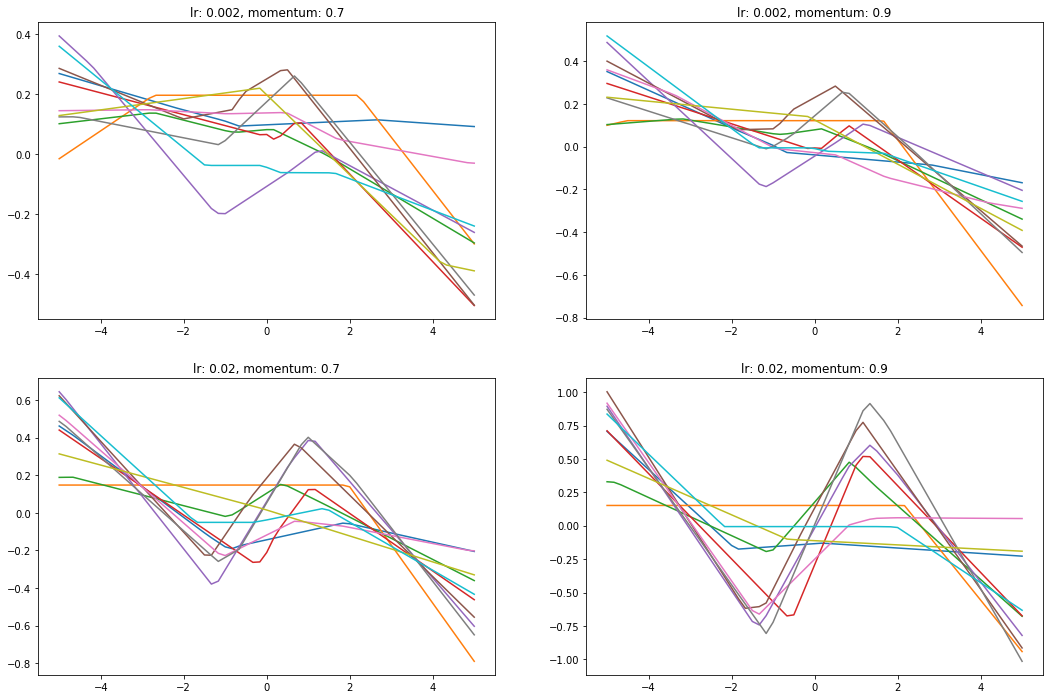

In [75]:
fig, axs = plt.subplots(len(param_frame[facet_x].unique()), len(param_frame[facet_y].unique()), figsize = (18,12))
for xpos in range(len(param_frame[facet_x].unique())):
    for ypos in range(len(param_frame[facet_x].unique())):
        xval = param_frame[facet_x].unique()[xpos]
        yval = param_frame[facet_y].unique()[ypos]
        print(xval)
        print(yval)
        data = frame[frame[facet_x] == xval]
        data = data[data[facet_y] == yval]
        for bee in range(len(data['bee'].unique())):
            bd = data[data['bee'] == bee].copy()
            axs[xpos,ypos].plot(bd['x'], bd['ypred'])
            axs[xpos,ypos].set_title(facet_x + ': ' + xval + ', '+ facet_y + ': ' + yval)

        
        